In [20]:
import pandas as pd
import seaborn as sns
from pathlib import Path
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

from math import log



base_path = Path("/misc/lmbraid19/hoffmaja/bruno/data")
augmix_paths = list(base_path.glob("augmix*/augmix*/ratio*/"))
standard_paths = list(base_path.glob("standard*/standard*/ratio*/"))
bp1 = Path("/misc/lmbraid19/hoffmaja/pumping_iron/data/cifar100_augmix_resnet18_000004/cifar100_augmix_resnet18_000004")
bp2 = Path("/misc/lmbraid19/hoffmaja/pumping_iron/data/cifar100_resnet18000002/cifar100_resnet18000002")
base_model_paths = [bp1, bp2]

In [22]:
flops_dict = {'uniform': {2: 70321015.0, 4: 35190225.0, 8: 17561987.0, 16: 8731804.0, 32: 4351797.0},
              'global_weight': {2: 97586975.0, 4: 65783902.0, 8: 41601243.0, 16: 25451394.0, 32: 15145018.0}}

In [23]:
def read_params(path):
    cfg = OmegaConf.load(path/"configs.yaml")
    if cfg.prune.method == "global_weight":
        flops = flops_dict["global_weight"][cfg.prune.ratio]
    else:
        flops = flops_dict["uniform"][cfg.prune.ratio]
    # return cfg.prune.ratio, cfg.prune.method
    return flops, cfg.prune.method

def build_df(path, with_params=True):
    df = pd.read_csv(path/"metrics.csv").iloc[-1]
    df = df.filter(regex="test_acc_*")
    if with_params:
        ratio, method = read_params(path)

        df["ratio"] = ratio
        df["method"] = method
    return df.to_frame().T

def build_all(with_params=True, **groups):
    dfs = []
    for name, paths in groups.items():
        for path in paths:
            df = build_df(path, with_params)
            df["group"] = name
            dfs.append(df)
    df = pd.concat(dfs, sort=True)
    df["clean_error"] = 1 - pd.to_numeric(df["test_acc_clean"])
    df["mCE"] = 1 - df.filter(regex="test_acc_*").mean(axis=1)
    return df

df = build_all(augmix=augmix_paths, standard=standard_paths)

In [24]:
df_baseline = build_all(augmix=[bp1], standard=[bp2], with_params=False)
df_baseline["ratio"] = None
df_baseline["method"] = "baseline"

In [25]:
df.sort_values(by=["method", "ratio", "group"]).to_csv("cifar100_base.csv")

In [31]:
df["MACs"] = df["ratio"]

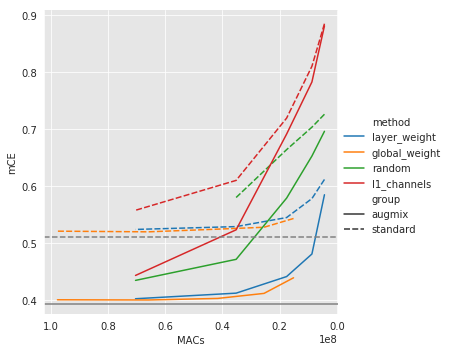

In [32]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
g = sns.relplot(data=df, x="MACs", y="mCE", hue="method", style="group", kind="line")
g.axes[0][0].axhline(df_baseline[df_baseline["group"]=="standard"]["mCE"].item(), ls="--", color="grey")
g.axes[0][0].axhline(df_baseline[df_baseline["group"]=="augmix"]["mCE"].item(), ls="-", color="grey")
g.axes[0][0].invert_xaxis()
plt.savefig("corrupted.png")

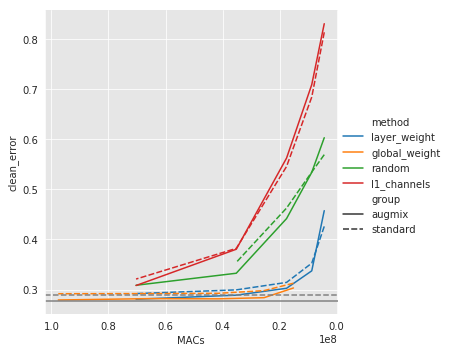

In [33]:
g = sns.relplot(data=df, x="MACs", y="clean_error", hue="method", style="group", kind="line")
g.axes[0][0].axhline(df_baseline[df_baseline["group"]=="standard"]["clean_error"].item(), ls="--", color="grey")
g.axes[0][0].axhline(df_baseline[df_baseline["group"]=="augmix"]["clean_error"].item(), ls="-", color="grey")
g.axes[0][0].invert_xaxis()
plt.savefig("clean.png")